In [11]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import errno

In [12]:
def read_img(data_dir):
    img = cv2.imread(data_dir, cv2.IMREAD_COLOR) #cv读图更快一些，但是是bgr排布
    if img is None:
        raise OSError(errno.ENOENT, "No such file", path)
    img = img.astype(np.float32)
    img = preprocess(img)
    return img

def show_img(img):
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.axis('off') # 不显示坐标轴
    plt.show()

def preprocess(img):
    img = img[...,::-1]#bgr to rgb
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    img = img[np.newaxis,:,:,:]
    img = img/255.0
    #img -= np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    return img

def tfDataAug(input_image,batch_size=1):
    noise = tf.random_normal(shape=tf.shape(input_image), mean=0, stddev=0.2, dtype=tf.float32)
    noise_image = tf.cast(input_image, tf.float32)/255.0 + noise
    noise_image = tf.clip_by_value(noise_image, 0, 1.0)
    #noise_image = noise_image*255.0
    image = tf.random_crop(noise_image, size=(batch_size,224,224, 3))
    return image

def get_img_sample(data_dir,dataAug=False):
    if dataAug:
        img = cv2.imread(data_dir, cv2.IMREAD_COLOR)
        img = img.astype(np.float32)
        img = img[...,::-1]
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img[np.newaxis,:,:,:]
    else:
        img = read_img(data_dir)
        #img = np.stack(img).astype(np.float32)
    return img

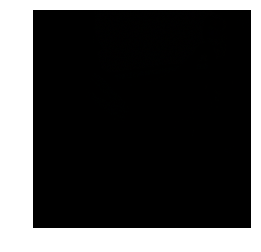

[[  89.93334198   90.7333374    91.53334045]
 [  94.38667297   95.02667236   95.88000488]
 [  99.06667328   99.68000031  100.88000488]]


In [3]:
if __name__=='__main__':
    data_dir0 = 'data/train/c0/img_34.jpg'
    data_dir1 = 'data/train/c0/img_208.jpg'
    data_dir2 = 'data/train/c0/img_262.jpg'
    batch_size =3
    img =[]
    img_tmp0 = get_img_sample(data_dir0,dataAug=True)
    img_tmp1 = get_img_sample(data_dir1,dataAug=True)
    img_tmp2 = get_img_sample(data_dir2,dataAug=True)
    img.append(img_tmp0)
    img.append(img_tmp1)
    img.append(img_tmp2)
    img = np.array(img).reshape(batch_size,256,256,3)
    img = tfDataAug(img,batch_size=batch_size)
    #img = img - tf.reshape(tf.constant([123.68, 116.779, 103.939]),(1,1,1,3))
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        img_tmp= sess.run(img)
    show_img(img_tmp[2])
    print(img_tmp0[0,:3,:3,1])

In [ ]:
def creat_flip_mirror_rotate_img():
    driver_imgs_list = pd.read_csv('data/driver_imgs_list.csv')
    train_data = driver_imgs_list.values
    for i in range(train_data.shape[0]):
        img_dir = os.path.join('data','train', train_data[i,1])
        img = cv2.imread(img_dir  + '\\'+ train_data[i,2], cv2.IMREAD_COLOR)
        h_flip = cv2.flip(img, 1)
        v_flip = cv2.flip(img, 0)
        rotated= np.rot90(img)
        h_flip_name = train_data[i,2].split('.')[0] + '_1'+".jpg"
        v_flip_name = train_data[i,2].split('.')[0] + '_2'+".jpg"
        rotated_name = train_data[i,2].split('.')[0] + '_3'+".jpg"
        cv2.imwrite(img_dir + "\\" + h_flip_name, h_flip)
        cv2.imwrite(img_dir + "\\" + v_flip_name, v_flip)
        cv2.imwrite(img_dir + "\\" + rotated_name, rotated)
        driver_imgs_list.loc[len(driver_imgs_list)]=[train_data[i,0],train_data[i,1],h_flip_name]
        driver_imgs_list.loc[len(driver_imgs_list)]=[train_data[i,0],train_data[i,1],v_flip_name]
        driver_imgs_list.loc[len(driver_imgs_list)]=[train_data[i,0],train_data[i,1],rotated_name]
    driver_imgs_list.to_csv('data/Aug_driver_imgs_list.csv',index=False,sep=',')